In [211]:
# Import stuff in 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime


%matplotlib inline
random.seed(148)

In [212]:
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc

In [213]:
#Convert date type/column into datetime object
def convertDateData(column, data):
    data[column] = pd.to_datetime(data[column], format='%m/%Y')
    return data

def convertColumnToFloat(column, data):
    data[column] = pd.to_numeric(data[column])
    return data

## Load Data

In [214]:
brand_details = pd.read_csv('data/BrandDetails.csv')
brand_details = brand_details.sample(frac=1).reset_index(drop=True)

brand_total_sales_data = pd.read_csv('data/BrandTotalSales.csv')
brand_total_sales_data = brand_total_sales_data.sample(frac=1).reset_index(drop=True)

brand_arp_data = pd.read_csv('data/BrandAverageRetailPrice.csv')
brand_arp_data = brand_arp_data.sample(frac=1).reset_index(drop=True)

brand_total_units_data = pd.read_csv('data/BrandTotalUnits.csv')
brand_total_units_data = brand_total_units_data.sample(frac=1).reset_index(drop=True)

In [215]:
brand_details.head()

,State,Channel,Category L1,Category L2,Category L3,Category L4,Category L5,Brand,Product Description,Total Sales ($),...,Total THC,Total CBD,Contains CBD,Pax Filter,Strain,Is Flavored,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment
0,California,Licensed,Inhaleables,Concentrates,Dabbable Concentrates,Live Resin,NaN,Live Resin Project,Live Resin Project - Sunset Blood Orange - Liv...,574.6208080000000,...,0,0,THC Only,NaN,Sunset Blood Orange,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$35.00 to $39.99
1,California,Licensed,Inhaleables,Concentrates,Dabbable Concentrates,Live Resin,NaN,Jetty Extracts,Jetty Extracts - Wedding Cake - Live Resin,"7,005.462023",...,0,0,THC Only,NaN,Wedding Cake,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$55.00 to $59.99
2,California,Licensed,Inhaleables,Pre-Rolled,Infused Pre-Rolled,NaN,NaN,Ganja Gold,Ganja Gold - Blue Tarantula - Motorbreath - In...,"88,406.464954",...,0,0,THC Only,NaN,Motorbreath,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$20.00 to $24.99
3,California,Licensed,Inhaleables,Concentrates,Vape,Vape Cartridge,Unspecified Cartridge,Concentrate,Concentrate - Hybrid Strain Blends - Unspecifi...,979.594647,...,0,0,THC Only,Not Pax,NaN,NaN,Not Mood Specific,Generic Vendors,Generic Items,$05.00 to $9.99
4,California,Licensed,Inhaleables,Concentrates,Vape,Vape Disposable,Distillate Disposable,Pure Vape,Pure Vape - Jack Herer - Distillate Disposable...,235.440842,...,0,0,THC Only,Not Pax,Jack Herer,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,Over $100


## Remove california field
#### We can see that all state fields are "California" so we can probably drop this

In [216]:
not_california = brand_details[~brand_details["State"].isin(["California"])]
not_california.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   State                0 non-null      object 
 1   Channel              0 non-null      object 
 2   Category L1          0 non-null      object 
 3   Category L2          0 non-null      object 
 4   Category L3          0 non-null      object 
 5   Category L4          0 non-null      object 
 6   Category L5          0 non-null      object 
 7   Brand                0 non-null      object 
 8   Product Description  0 non-null      object 
 9   Total Sales ($)      0 non-null      object 
 10  Total Units          0 non-null      object 
 11  ARP                  0 non-null      float64
 12  Flavor               0 non-null      object 
 13  Items Per Pack       0 non-null      int64  
 14  Item Weight          0 non-null      object 
 15  Total THC            0 non-null      object 
 16  To

In [217]:
brand_details = brand_details.drop("State", axis=1)
brand_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144977 entries, 0 to 144976
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Channel              144977 non-null  object 
 1   Category L1          144977 non-null  object 
 2   Category L2          144977 non-null  object 
 3   Category L3          144245 non-null  object 
 4   Category L4          102618 non-null  object 
 5   Category L5          50135 non-null   object 
 6   Brand                144977 non-null  object 
 7   Product Description  144977 non-null  object 
 8   Total Sales ($)      144977 non-null  object 
 9   Total Units          144977 non-null  object 
 10  ARP                  144977 non-null  float64
 11  Flavor               7807 non-null    object 
 12  Items Per Pack       144977 non-null  int64  
 13  Item Weight          64454 non-null   object 
 14  Total THC            144977 non-null  object 
 15  Total CBD        

## Reorder brand_details
#### In order to have brand in first column,making it easier for us to read

In [218]:
column_reordering = ["Brand", "Product Description", "Category L1", "Category L2", "Category L3", "Category L4", "Category L5", "Total Sales ($)", "Total Units", "ARP", "Channel", "Flavor", "Items Per Pack", "Item Weight", "Total THC", "Total CBD", "Contains CBD", "Pax Filter", "Strain", "Is Flavored", "Mood Effect", "Generic Vendor", "Generic Items", "$5 Price Increment"]
brand_details = brand_details.reindex(columns=column_reordering)
brand_details = brand_details.sort_values(by=['Brand'], ascending = True)
brand_details = brand_details.reset_index(drop = True)
brand_details.head()

,Brand,Product Description,Category L1,Category L2,Category L3,Category L4,Category L5,Total Sales ($),Total Units,ARP,...,Total THC,Total CBD,Contains CBD,Pax Filter,Strain,Is Flavored,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment
0,#BlackSeries,#BlackSeries - Vanilla Frosting - Flower (Gram),Inhaleables,Flower,Hybrid,NaN,NaN,"1,103.964857",85.86394100000000,12.857142,...,0,0,THC Only,NaN,Vanilla Frosting,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
1,#BlackSeries,#BlackSeries - Vanilla Frosting - Flower (Gram),Inhaleables,Flower,Hybrid,NaN,NaN,674.645211,42.931971000000000,15.714285,...,0,0,THC Only,NaN,Vanilla Frosting,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
2,#BlackSeries,#BlackSeries - Blueberry Slushy - Flower (Gram),Inhaleables,Flower,Sativa Dominant,NaN,NaN,"2,473.699102",157.417226,15.714285,...,0,0,THC Only,NaN,Blueberry Slushy,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
3,#BlackSeries,#BlackSeries - Blueberry Slushy - Flower (Gram),Inhaleables,Flower,Sativa Dominant,NaN,NaN,"14,589.916417","1,195.9888350000000",12.199041,...,0,0,THC Only,NaN,Blueberry Slushy,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
4,101 Cannabis Co.,101 Cannabis Co. - Super Silver Haze - Wax,Inhaleables,Concentrates,Dabbable Concentrates,Wax,NaN,435.843645,12.183847,35.772252,...,0,0,THC Only,NaN,Super Silver Haze,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$35.00 to $39.99


## Reorder brand_total_sales_data & Convert Months to datetime

In [219]:
bts_columns = ["Brand", "Months", "Total Sales ($)"]
brand_total_sales_data = brand_total_sales_data.reindex(columns=bts_columns)
brand_total_sales_data = brand_total_sales_data.sort_values(by=["Brand", "Months"], ascending=True)
brand_total_sales_data = brand_total_sales_data.reset_index(drop=True)
brand_total_sales_data.head()

,Brand,Months,Total Sales ($)
0,#BlackSeries,01/2021,"9,739.4234"
1,#BlackSeries,02/2021,"9,102.802187000000"
2,#BlackSeries,08/2020,"25,352.135918000000"
3,101 Cannabis Co.,01/2020,"11,790.663567"
4,101 Cannabis Co.,01/2021,"8,059.176644000000"


#### Convert to datetime

In [220]:
brand_total_sales_data = convertDateData("Months", brand_total_sales_data)
brand_total_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Brand            25279 non-null  object        
 1   Months           25279 non-null  datetime64[ns]
 2   Total Sales ($)  25279 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 592.6+ KB


## Create new dataframe | Concatination of all csv files

### Initialize with brand_total_sales_data information

In [221]:
# Our new dataframe that will be a merging of all other csv files
df = pd.DataFrame( columns = ['Brand', 'Month',"Total Sales ($)", "ARP", "Total Units"])
df["Brand"] = brand_total_sales_data["Brand"]
df["Month"] = brand_total_sales_data["Months"]
df["Total Sales ($)"] = brand_total_sales_data["Total Sales ($)"]

### Convert brand_arp_data months to datetime

In [222]:
brand_arp_data = convertDateData("Months", brand_arp_data)

### Append arp data to dataframe

In [223]:
appendings = []
for index, row in brand_arp_data.iterrows():
    if index > -1:
        # Column values to match
        local_month = row["Months"]
        local_brand = row["Brands"]

        copy_value = row["ARP"]
        
        # Find matching row in main df dataframe
        matched_row = df[["Brand", "Month", "Total Sales ($)", "ARP", "Total Units"]][(df["Brand"] == local_brand) & (df["Month"] == local_month)]
        
        # if row was found
        if not matched_row.empty:
            matched_index = matched_row.index.tolist()[0]
            appendings.append((matched_index, copy_value))


# append new values
for appending in appendings:
    index = appending[0]
    arp = appending[1]
    df.iat[index, df.columns.get_loc('ARP')] = arp

#### Our updated dataframe

In [224]:
df.head(10)

,Brand,Month,Total Sales ($),ARP,Total Units
0,#BlackSeries,2021-01-01,"9,739.4234",13.611428,NaN
1,#BlackSeries,2021-02-01,"9,102.802187000000",11.873182,NaN
2,#BlackSeries,2020-08-01,"25,352.135918000000",15.684913,NaN
3,101 Cannabis Co.,2020-01-01,"11,790.663567",34.134929,NaN
4,101 Cannabis Co.,2021-01-01,"8,059.176644000000",32.206812,NaN
5,101 Cannabis Co.,2020-02-01,"20,266.761007000000",29.091388,NaN
6,101 Cannabis Co.,2021-02-01,"13,712.773455000000",34.643599,NaN
7,101 Cannabis Co.,2020-03-01,"30,465.470533000000",32.293498,NaN
8,101 Cannabis Co.,2021-03-01,"24,347.90462",35.448267,NaN
9,101 Cannabis Co.,2020-04-01,"23,465.657692000000",32.934344,NaN


### Convert brand_total_units_data months to datetime

In [225]:
brand_total_units_data = convertDateData("Months", brand_total_units_data)

### Append total_units_data to dataframe

#### Find what to append

In [226]:

appendings2 = []
for index, row in brand_total_units_data.iterrows():
    if index > -1:
        local_month = row["Months"]
        local_brand = row["Brands"]
        copy_value = row["Total Units"]
        matched_row = df[["Brand", "Month", "Total Sales ($)", "ARP", "Total Units"]][(df["Brand"] == local_brand) & (df["Month"] == local_month)]
        if not matched_row.empty:
            matched_index = matched_row.index.tolist()[0]
            appendings2.append((matched_index, copy_value))



#### Append to dataframe

In [227]:
for appending in appendings2:
    index = appending[0]
    tu = appending[1].rstrip("0")
    tu = float("".join(tu.split(",")))
    df.iat[index, df.columns.get_loc('Total Units')] = tu

## Convert columns (arp, sales, units) to float

### Convert total units and arp to float type

In [228]:
df = convertColumnToFloat("Total Units", df)
df = convertColumnToFloat("ARP", df)

### Stripe comma and extra unneeded 0's from right

In [229]:
df["Total Sales ($)"] = df["Total Sales ($)"].apply(lambda x: "".join(x.rstrip("0").split(",")))

In [230]:
df.head(20)

,Brand,Month,Total Sales ($),ARP,Total Units
0,#BlackSeries,2021-01-01,9739.4234,13.611428,715.532838
1,#BlackSeries,2021-02-01,9102.802187,11.873182,766.669135
2,#BlackSeries,2020-08-01,25352.135918,15.684913,1616.339004
3,101 Cannabis Co.,2020-01-01,11790.663567,34.134929,345.413448
4,101 Cannabis Co.,2021-01-01,8059.176644,32.206812,250.232050
5,101 Cannabis Co.,2020-02-01,20266.761007,29.091388,696.658431
6,101 Cannabis Co.,2021-02-01,13712.773455,34.643599,395.824159
7,101 Cannabis Co.,2020-03-01,30465.470533,32.293498,943.393328
8,101 Cannabis Co.,2021-03-01,24347.90462,35.448267,686.857410
9,101 Cannabis Co.,2020-04-01,23465.657692,32.934344,712.498102


### Remove rows/months where there were no sales
#### We assume that the brand was not sold that month which we ignore and assume all brands will be sold in predicted month

In [231]:

# not sure if I need this df[["Brand","Month", "Total Sales ($)", "ARP", "Total Units"]][(df["Total Sales ($)"] == '')]

df = df[df['Total Sales ($)'] != '']


#### Ensure no sales months exist where the brand was elected to not be sold

In [232]:

df[["Brand","Month", "Total Sales ($)", "ARP", "Total Units"]][(df["Total Sales ($)"] == '')]

,Brand,Month,Total Sales ($),ARP,Total Units


### Convert total sales to float

In [233]:
df["Total Sales ($)"] = df["Total Sales ($)"].apply(lambda x: float(x))

df.info()
# Concatination of the 3 time series files, is done

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25276 entries, 0 to 25278
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Brand            25276 non-null  object        
 1   Month            25276 non-null  datetime64[ns]
 2   Total Sales ($)  25276 non-null  float64       
 3   ARP              25276 non-null  float64       
 4   Total Units      25276 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.2+ MB


In [234]:
#Brainstorming notes
# could come up with some fields like
# offers_concentrates, offers_edibles, offers_prerolls, offers_flower, 
# offers_topicals, offers_edibles, offers_devices
# offers_sublinguals,offers_other_cannabis_products,
# num_of_products

#Time series features
#time series: sales_last_6_months, sales_last_3_months, sales_last_1_month

brand_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144977 entries, 0 to 144976
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Brand                144977 non-null  object 
 1   Product Description  144977 non-null  object 
 2   Category L1          144977 non-null  object 
 3   Category L2          144977 non-null  object 
 4   Category L3          144245 non-null  object 
 5   Category L4          102618 non-null  object 
 6   Category L5          50135 non-null   object 
 7   Total Sales ($)      144977 non-null  object 
 8   Total Units          144977 non-null  object 
 9   ARP                  144977 non-null  float64
 10  Channel              144977 non-null  object 
 11  Flavor               7807 non-null    object 
 12  Items Per Pack       144977 non-null  int64  
 13  Item Weight          64454 non-null   object 
 14  Total THC            144977 non-null  object 
 15  Total CBD        

## Brand features


In [235]:
unique_brands = df["Brand"].unique()

### Dictionary to keep track of what type of product each brand sells

#### Create 2 dictionaries, one to keep track how many products and product type each brand has, and one to keep track of what types of products each brand has 

In [236]:
brand_product_dictionary = {}
brand_product_count_dictionary = {}


#### We are going to first determine which brands sell what kinds of products, and append that data to our dataframe

In [237]:
brand_details["Category L2"].unique()

array(['Flower', 'Concentrates', 'Pre-Rolled', 'Topicals', 'Edibles',
       'Devices', 'Sublinguals', 'Other Cannabis', 'Accessories',
       'Non Infused Food', 'Apparel', 'Grow Supplies', 'Shake/Trim/Lite'],
      dtype=object)

#### Populate dictionaries

In [238]:
product_types = [
    "Flower",
    "Concentrates",
    "Pre-Rolled",
    "Topicals",
    "Edibles",
    "Devices",
    "Sublinguals",
    "Other Cannabis",
    "Accessories",
    "Non Infused Food",
    "Apparel",
    "Grow Supplies",
    "Shake/Trim/Lite"
]

for brand_name in unique_brands:
    brand_result = brand_details[["Brand", "Category L2"]][(brand_details["Brand"] == brand_name)]
    brand_offerings = []
    
    for product_type in product_types:
        if product_type in brand_result["Category L2"].values:
            brand_offerings.append(product_type)
            
    # The kinds of products offered
    brand_product_dictionary[brand_name] = brand_offerings
    # How many kinds, and how many offered total
    brand_product_count_dictionary[brand_name] = [len(brand_offerings), len(brand_result)]

### Initialize new brand level features

In [239]:
# do we want to have all of these initialized to 0's
df["offers_flower"] = 0
df["offers_concentrates"] = 0
df["offers_prerolls"] = 0
df["offers_topicals"] = 0
df["offers_edibles"] = 0
df["offers_devices"] = 0
df["offers_sublinguals"] = 0
df["offers_other_cannabis"] = 0
df["offers_accessories"] = 0
df["offers_noninfused_food"] = 0
df["offers_apparel"] = 0
df["offers_grow_supplies"] = 0
df["offers_shake"] = 0
df["num_products"] = 0
df["num_product_types"] = 0

#### A couple of constants used as helpers elsewhere

In [240]:
# df_brand_name = "101 Cannabis Co."
df_return_rows = [
    "Brand",
    "Month",
    "Total Sales ($)",
    "ARP",
    "Total Units",
    "offers_flower", 
    "offers_concentrates", 
    "offers_prerolls", 
    "offers_topicals", 
    "offers_edibles", 
    "offers_devices", 
    "offers_sublinguals", 
    "offers_other_cannabis", 
    "offers_accessories", 
    "offers_noninfused_food", 
    "offers_apparel", 
    "offers_grow_supplies", 
    "offers_shake",
    "num_products",
    "num_product_types"
]


product_to_column_map = {
    "Flower": "offers_flower",
    "Concentrates": "offers_concentrates",
    "Pre-Rolled": "offers_prerolls",
    "Topicals": "offers_topicals",
    "Edibles": "offers_edibles",
    "Devices": "offers_devices",
    "Sublinguals": "offers_sublinguals",
    "Other Cannabis": "offers_other_cannabis",
    "Accessories": "offers_accessories",
    "Non Infused Food": "offers_noninfused_food",
    "Apparel": "offers_apparel",
    "Grow Supplies": "offers_grow_supplies",
    "Shake/Trim/Lite": "offers_shake",
}

#### Update our data to correct column information

In [241]:
for df_brand_name in unique_brands:
    
    # All rows for this specific df_brand_name
    df_brand = df[df_return_rows][(df["Brand"] == df_brand_name)]

    # From dictionary
    available_products = brand_product_dictionary[df_brand_name] # ["Concentrates", "Flower"]
    not_offered_by_brand = [x for x in product_types if x not in available_products ]
    offered_by_brand = [x for x in product_types if x in available_products ]
    
    # Set specific product types
    for product in not_offered_by_brand:
        col = product_to_column_map[product]
        df_brand[col] = 0
    for product in offered_by_brand:
        col = product_to_column_map[product]
        df_brand[col] = 1
        
    # Set how many products/types
    df_brand["num_product_types"] = brand_product_count_dictionary[df_brand_name][0]
    df_brand["num_products"] = brand_product_count_dictionary[df_brand_name][1]
    
    # Update main dataframe
    df[(df["Brand"] == df_brand_name)] = df_brand



#### Preview new data fields

In [242]:
# See new data
df.head(20)

,Brand,Month,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,offers_devices,offers_sublinguals,offers_other_cannabis,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types
0,#BlackSeries,2021-01-01,9739.423400,13.611428,715.532838,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1
1,#BlackSeries,2021-02-01,9102.802187,11.873182,766.669135,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1
2,#BlackSeries,2020-08-01,25352.135918,15.684913,1616.339004,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1
3,101 Cannabis Co.,2020-01-01,11790.663567,34.134929,345.413448,0,1,1,0,0,0,0,0,0,0,0,0,0,77,2
4,101 Cannabis Co.,2021-01-01,8059.176644,32.206812,250.232050,0,1,1,0,0,0,0,0,0,0,0,0,0,77,2
5,101 Cannabis Co.,2020-02-01,20266.761007,29.091388,696.658431,0,1,1,0,0,0,0,0,0,0,0,0,0,77,2
6,101 Cannabis Co.,2021-02-01,13712.773455,34.643599,395.824159,0,1,1,0,0,0,0,0,0,0,0,0,0,77,2
7,101 Cannabis Co.,2020-03-01,30465.470533,32.293498,943.393328,0,1,1,0,0,0,0,0,0,0,0,0,0,77,2
8,101 Cannabis Co.,2021-03-01,24347.904620,35.448267,686.857410,0,1,1,0,0,0,0,0,0,0,0,0,0,77,2
9,101 Cannabis Co.,2020-04-01,23465.657692,32.934344,712.498102,0,1,1,0,0,0,0,0,0,0,0,0,0,77,2


### Sort each brand by ascending date
#### This is in order to more easily construct time series features

In [243]:
#correct, works easier & better
df_sorted = df.sort_values(["Brand", "Month"]).reset_index(drop=True)

In [244]:
df_sorted

,Brand,Month,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,offers_devices,offers_sublinguals,offers_other_cannabis,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types
0,#BlackSeries,2020-08-01,25352.135918,15.684913,1616.339004,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1
1,#BlackSeries,2021-01-01,9739.423400,13.611428,715.532838,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1
2,#BlackSeries,2021-02-01,9102.802187,11.873182,766.669135,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1
3,101 Cannabis Co.,2019-11-01,4465.040321,34.066667,131.067720,0,1,1,0,0,0,0,0,0,0,0,0,0,77,2
4,101 Cannabis Co.,2020-01-01,11790.663567,34.134929,345.413448,0,1,1,0,0,0,0,0,0,0,0,0,0,77,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25271,iKrusher,2020-05-01,10892.946263,10.667051,1021.176952,0,0,0,0,0,1,0,0,0,0,0,0,0,4,1
25272,iKrusher,2020-06-01,7218.730212,10.750000,671.509800,0,0,0,0,0,1,0,0,0,0,0,0,0,4,1
25273,iKrusher,2021-07-01,7757.371062,19.189128,404.258649,0,0,0,0,0,1,0,0,0,0,0,0,0,4,1
25274,iKrusher,2021-08-01,18903.670968,19.144384,987.426417,0,0,0,0,0,1,0,0,0,0,0,0,0,4,1


In [245]:
# THINK IT BROKE HERE
df_sorted.loc[:, "Previous Month Total Units"] = df_sorted.loc[:, "Total Units"].shift(1)


df_sorted

,Brand,Month,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,...,offers_sublinguals,offers_other_cannabis,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,Previous Month Total Units
0,#BlackSeries,2020-08-01,25352.135918,15.684913,1616.339004,1,0,0,0,0,...,0,0,0,0,0,0,0,4,1,NaN
1,#BlackSeries,2021-01-01,9739.423400,13.611428,715.532838,1,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1616.339004
2,#BlackSeries,2021-02-01,9102.802187,11.873182,766.669135,1,0,0,0,0,...,0,0,0,0,0,0,0,4,1,715.532838
3,101 Cannabis Co.,2019-11-01,4465.040321,34.066667,131.067720,0,1,1,0,0,...,0,0,0,0,0,0,0,77,2,766.669135
4,101 Cannabis Co.,2020-01-01,11790.663567,34.134929,345.413448,0,1,1,0,0,...,0,0,0,0,0,0,0,77,2,131.067720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25271,iKrusher,2020-05-01,10892.946263,10.667051,1021.176952,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,45.535074
25272,iKrusher,2020-06-01,7218.730212,10.750000,671.509800,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,1021.176952
25273,iKrusher,2021-07-01,7757.371062,19.189128,404.258649,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,671.509800
25274,iKrusher,2021-08-01,18903.670968,19.144384,987.426417,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,404.258649


In [246]:
#FOR ANTHONY: IGNORE THESE BOTTOM TWO JUST KEEP ADDING ON, WAS THINKING WE MIGHT USE THESE LATER
def countProductTypeByBrand(data, brand, product_type, fields_to_return):
    result = data[fields_to_return][(data["Brand"] == brand)]
    return result.shape[0]

print(countProductTypeByBrand(brand_details, brand_name, "Flower", ["Brand", "Category L2"]))

4


In [247]:
#prev month total sales and prev month arp and 3mo rolling average
df_sorted.loc[:, "Previous Month Total Sales"] = df_sorted.loc[:, "Total Sales ($)"].shift(1)
df_sorted.loc[:, "Previous Month ARP"] = df_sorted.loc[:, "ARP"].shift(1)

In [248]:
df_sorted.head(40)


,Brand,Month,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,...,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,Previous Month Total Units,Previous Month Total Sales,Previous Month ARP
0,#BlackSeries,2020-08-01,25352.135918,15.684913,1616.339004,1,0,0,0,0,...,0,0,0,0,0,4,1,NaN,NaN,NaN
1,#BlackSeries,2021-01-01,9739.423400,13.611428,715.532838,1,0,0,0,0,...,0,0,0,0,0,4,1,1616.339004,25352.135918,15.684913
2,#BlackSeries,2021-02-01,9102.802187,11.873182,766.669135,1,0,0,0,0,...,0,0,0,0,0,4,1,715.532838,9739.423400,13.611428
3,101 Cannabis Co.,2019-11-01,4465.040321,34.066667,131.067720,0,1,1,0,0,...,0,0,0,0,0,77,2,766.669135,9102.802187,11.873182
4,101 Cannabis Co.,2020-01-01,11790.663567,34.134929,345.413448,0,1,1,0,0,...,0,0,0,0,0,77,2,131.067720,4465.040321,34.066667
5,101 Cannabis Co.,2020-02-01,20266.761007,29.091388,696.658431,0,1,1,0,0,...,0,0,0,0,0,77,2,345.413448,11790.663567,34.134929
6,101 Cannabis Co.,2020-03-01,30465.470533,32.293498,943.393328,0,1,1,0,0,...,0,0,0,0,0,77,2,696.658431,20266.761007,29.091388
7,101 Cannabis Co.,2020-04-01,23465.657692,32.934344,712.498102,0,1,1,0,0,...,0,0,0,0,0,77,2,943.393328,30465.470533,32.293498
8,101 Cannabis Co.,2020-05-01,21348.394472,34.441725,619.841032,0,1,1,0,0,...,0,0,0,0,0,77,2,712.498102,23465.657692,32.934344
9,101 Cannabis Co.,2020-06-01,14111.757773,33.114497,426.150450,0,1,1,0,0,...,0,0,0,0,0,77,2,619.841032,21348.394472,34.441725


In [249]:
#remove previous month entries where the values overflowed across companies
#setting the values to 0 if its the first month
df_cleaned = df_sorted
b = ''
for index, row in df_cleaned.iterrows():
    if b != row['Brand']:
        #first month of brand's existence
        #set prev month values to 0
        df_cleaned.at[index,'Previous Month Total Units'] = 0
        df_cleaned.at[index,'Previous Month Total Sales'] = 0
        df_cleaned.at[index,'Previous Month ARP'] = 0
    b = row['Brand']
    
df_cleaned.head(40)

,Brand,Month,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,...,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,Previous Month Total Units,Previous Month Total Sales,Previous Month ARP
0,#BlackSeries,2020-08-01,25352.135918,15.684913,1616.339004,1,0,0,0,0,...,0,0,0,0,0,4,1,0.000000,0.000000,0.000000
1,#BlackSeries,2021-01-01,9739.423400,13.611428,715.532838,1,0,0,0,0,...,0,0,0,0,0,4,1,1616.339004,25352.135918,15.684913
2,#BlackSeries,2021-02-01,9102.802187,11.873182,766.669135,1,0,0,0,0,...,0,0,0,0,0,4,1,715.532838,9739.423400,13.611428
3,101 Cannabis Co.,2019-11-01,4465.040321,34.066667,131.067720,0,1,1,0,0,...,0,0,0,0,0,77,2,0.000000,0.000000,0.000000
4,101 Cannabis Co.,2020-01-01,11790.663567,34.134929,345.413448,0,1,1,0,0,...,0,0,0,0,0,77,2,131.067720,4465.040321,34.066667
5,101 Cannabis Co.,2020-02-01,20266.761007,29.091388,696.658431,0,1,1,0,0,...,0,0,0,0,0,77,2,345.413448,11790.663567,34.134929
6,101 Cannabis Co.,2020-03-01,30465.470533,32.293498,943.393328,0,1,1,0,0,...,0,0,0,0,0,77,2,696.658431,20266.761007,29.091388
7,101 Cannabis Co.,2020-04-01,23465.657692,32.934344,712.498102,0,1,1,0,0,...,0,0,0,0,0,77,2,943.393328,30465.470533,32.293498
8,101 Cannabis Co.,2020-05-01,21348.394472,34.441725,619.841032,0,1,1,0,0,...,0,0,0,0,0,77,2,712.498102,23465.657692,32.934344
9,101 Cannabis Co.,2020-06-01,14111.757773,33.114497,426.150450,0,1,1,0,0,...,0,0,0,0,0,77,2,619.841032,21348.394472,34.441725


In [250]:
df_sorted = df_cleaned
df_sorted.head(50)

,Brand,Month,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,...,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,Previous Month Total Units,Previous Month Total Sales,Previous Month ARP
0,#BlackSeries,2020-08-01,25352.135918,15.684913,1616.339004,1,0,0,0,0,...,0,0,0,0,0,4,1,0.000000,0.000000,0.000000
1,#BlackSeries,2021-01-01,9739.423400,13.611428,715.532838,1,0,0,0,0,...,0,0,0,0,0,4,1,1616.339004,25352.135918,15.684913
2,#BlackSeries,2021-02-01,9102.802187,11.873182,766.669135,1,0,0,0,0,...,0,0,0,0,0,4,1,715.532838,9739.423400,13.611428
3,101 Cannabis Co.,2019-11-01,4465.040321,34.066667,131.067720,0,1,1,0,0,...,0,0,0,0,0,77,2,0.000000,0.000000,0.000000
4,101 Cannabis Co.,2020-01-01,11790.663567,34.134929,345.413448,0,1,1,0,0,...,0,0,0,0,0,77,2,131.067720,4465.040321,34.066667
5,101 Cannabis Co.,2020-02-01,20266.761007,29.091388,696.658431,0,1,1,0,0,...,0,0,0,0,0,77,2,345.413448,11790.663567,34.134929
6,101 Cannabis Co.,2020-03-01,30465.470533,32.293498,943.393328,0,1,1,0,0,...,0,0,0,0,0,77,2,696.658431,20266.761007,29.091388
7,101 Cannabis Co.,2020-04-01,23465.657692,32.934344,712.498102,0,1,1,0,0,...,0,0,0,0,0,77,2,943.393328,30465.470533,32.293498
8,101 Cannabis Co.,2020-05-01,21348.394472,34.441725,619.841032,0,1,1,0,0,...,0,0,0,0,0,77,2,712.498102,23465.657692,32.934344
9,101 Cannabis Co.,2020-06-01,14111.757773,33.114497,426.150450,0,1,1,0,0,...,0,0,0,0,0,77,2,619.841032,21348.394472,34.441725


In [251]:
# df_sorted.loc[:,'3mo Average Units'] = (df_sorted.loc[:,'Total Units'].shift(1) + df_sorted.loc[:,'Total Units'].shift(2) + df_sorted.loc[:,'Total Units'].shift(3))/3
# df_sorted.loc[:,'3mo Average Sales'] = (df_sorted.loc[:,'Total Sales ($)'].shift(1) + df_sorted.loc[:,'Total Sales ($)'].shift(2) + df_sorted.loc[:,'Total Sales ($)'].shift(3))/3
# df_sorted.loc[:,'3mo Average ARP']   = (df_sorted.loc[:,'ARP'].shift(1) + df_sorted.loc[:,'ARP'].shift(2) + df_sorted.loc[:,'ARP'].shift(3))/3

#JC : the three month averages are easy to compute ^^ however they seem to be causing more problems than theyre solving.
#the data captures the 3 month averages in its current state, we will just need to compute it if /  when we need it

In [264]:
#Reorder columns
cols = ['Brand', 'Month', 'Total Sales ($)', 'Total Units', 'ARP', 'Previous Month Total Sales', 'Previous Month Total Units', 'Previous Month ARP', 'num_products', 'num_product_types', 'offers_flower', 'offers_concentrates', 'offers_prerolls', 'offers_topicals', 'offers_edibles', 'offers_sublinguals', 'offers_other_cannabis', 'offers_accessories', 'offers_noninfused_food', 'offers_apparel', 'offers_grow_supplies', 'offers_shake']
df_sorted.reindex(columns=cols)

,Brand,Month,Total Sales ($),Total Units,ARP,Previous Month Total Sales,Previous Month Total Units,Previous Month ARP,num_products,num_product_types,...,offers_prerolls,offers_topicals,offers_edibles,offers_sublinguals,offers_other_cannabis,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake
0,#BlackSeries,2020-08-01,25352.135918,1616.339004,15.684913,0.000000,0.000000,0.000000,4,1,...,0,0,0,0,0,0,0,0,0,0
1,#BlackSeries,2021-01-01,9739.423400,715.532838,13.611428,25352.135918,1616.339004,15.684913,4,1,...,0,0,0,0,0,0,0,0,0,0
2,#BlackSeries,2021-02-01,9102.802187,766.669135,11.873182,9739.423400,715.532838,13.611428,4,1,...,0,0,0,0,0,0,0,0,0,0
3,101 Cannabis Co.,2019-11-01,4465.040321,131.067720,34.066667,0.000000,0.000000,0.000000,77,2,...,1,0,0,0,0,0,0,0,0,0
4,101 Cannabis Co.,2020-01-01,11790.663567,345.413448,34.134929,4465.040321,131.067720,34.066667,77,2,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25271,iKrusher,2020-05-01,10892.946263,1021.176952,10.667051,285.179135,45.535074,6.262846,4,1,...,0,0,0,0,0,0,0,0,0,0
25272,iKrusher,2020-06-01,7218.730212,671.509800,10.750000,10892.946263,1021.176952,10.667051,4,1,...,0,0,0,0,0,0,0,0,0,0
25273,iKrusher,2021-07-01,7757.371062,404.258649,19.189128,7218.730212,671.509800,10.750000,4,1,...,0,0,0,0,0,0,0,0,0,0
25274,iKrusher,2021-08-01,18903.670968,987.426417,19.144384,7757.371062,404.258649,19.189128,4,1,...,0,0,0,0,0,0,0,0,0,0


In [253]:
#JC: do you know why iKrusher is at the bottom? shouldnt we have zuma?

In [254]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [263]:
df = df_sorted
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25276 entries, 0 to 25275
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Brand                       25276 non-null  object        
 1   Month                       25276 non-null  datetime64[ns]
 2   Total Sales ($)             25276 non-null  float64       
 3   ARP                         25276 non-null  float64       
 4   Total Units                 25276 non-null  float64       
 5   offers_flower               25276 non-null  int64         
 6   offers_concentrates         25276 non-null  int64         
 7   offers_prerolls             25276 non-null  int64         
 8   offers_topicals             25276 non-null  int64         
 9   offers_edibles              25276 non-null  int64         
 10  offers_devices              25276 non-null  int64         
 11  offers_sublinguals          25276 non-null  int64     

In [256]:
df.describe()

,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,offers_devices,offers_sublinguals,...,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,Previous Month Total Units,Previous Month Total Sales,Previous Month ARP
count,2.527600e+04,25276.000000,2.527600e+04,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,...,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,2.527600e+04,2.527600e+04,25276.000000
mean,4.094214e+05,22.682424,2.886553e+04,0.365287,0.356860,0.336090,0.079483,0.221158,0.125771,0.091747,...,0.028169,0.002928,0.001464,0.001464,0.001464,178.979665,1.662724,2.793484e+04,3.972716e+05,21.343841
std,1.596113e+06,19.802357,1.617249e+05,0.481520,0.479083,0.472379,0.270496,0.415035,0.331598,0.288674,...,0.165459,0.054030,0.038233,0.038233,0.038233,482.397225,1.255772,1.596175e+05,1.575933e+06,19.922400
min,1.105180e-01,0.007437,3.842953e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.391597e+04,10.514253,7.173228e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,5.245793e+02,1.096943e+04,9.446243
50%,6.219871e+04,17.035672,3.606163e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,1.000000,3.269256e+03,5.743262e+04,16.022459
75%,2.473617e+05,31.505853,1.564512e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,162.000000,2.000000,1.482116e+04,2.383066e+05,30.463611
max,4.036351e+07,700.874984,5.248082e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,9004.000000,7.000000,5.248082e+06,4.036351e+07,700.874984


In [258]:
#check for any null values
df.columns[df.isna().any()].tolist()

[]

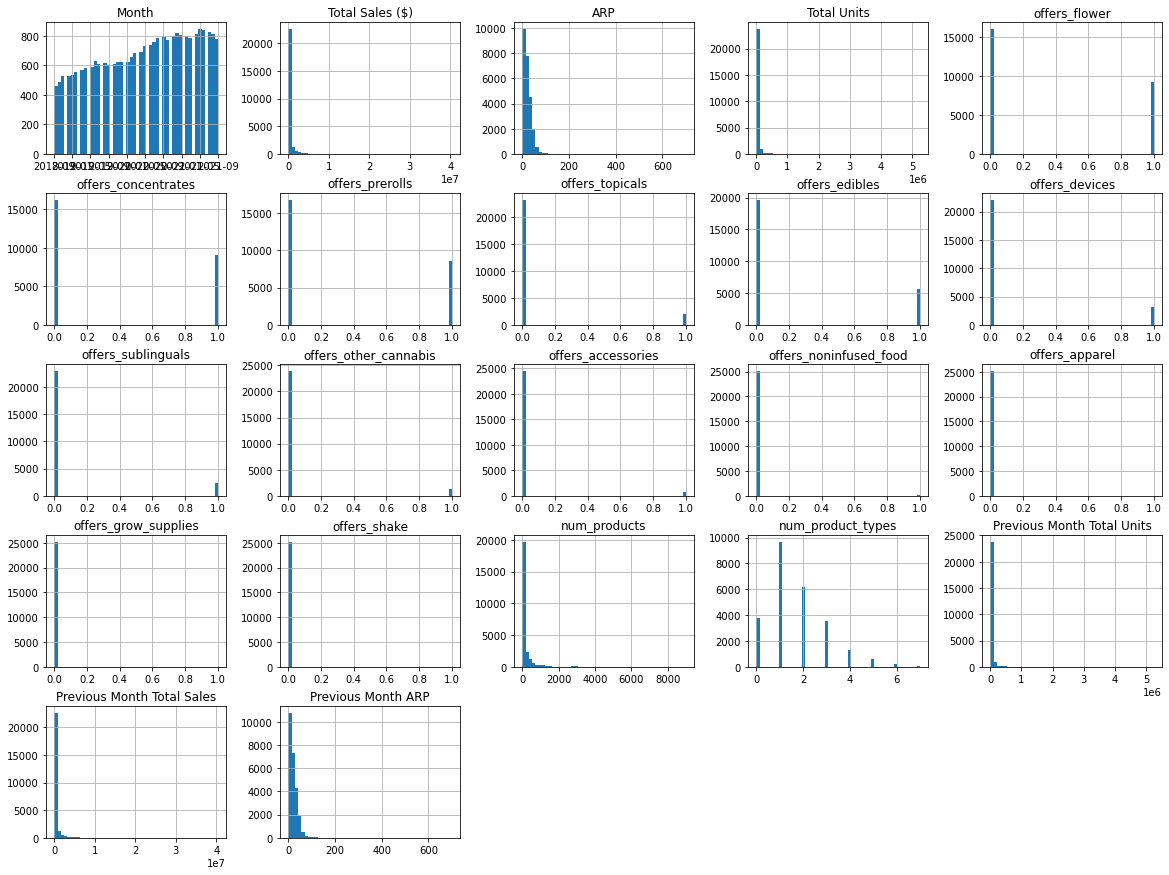

In [259]:
df.hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:>

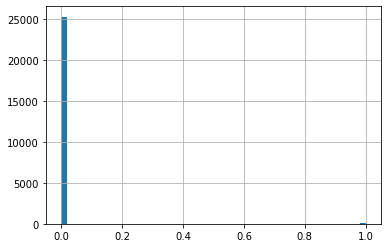

In [261]:
#based on the histograms, we might want to drop some of these offers columns, some are 25,000 zeroes, maybe we should explore
#further here 
df['offers_grow_supplies'].hist(bins=50)

,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,offers_devices,offers_sublinguals,...,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,Previous Month Total Units,Previous Month Total Sales,Previous Month ARP
Total Sales ($),1.000000,-0.011378,0.875595,0.088232,0.124388,0.073648,0.059993,0.094386,0.161188,0.071517,...,-0.025345,0.023057,0.031529,0.031529,0.004773,0.500699,0.231575,0.851950,0.974939,-0.000652
ARP,-0.011378,1.000000,-0.076604,-0.292317,0.116308,-0.176309,0.228659,-0.005285,0.114742,0.194397,...,-0.060217,-0.033229,-0.034277,-0.034277,-0.037836,0.090417,-0.004317,-0.074397,-0.011134,0.851365
Total Units,0.875595,-0.076604,1.000000,0.122133,0.034118,0.066221,-0.010908,0.017009,0.033053,-0.002352,...,-0.002563,0.055176,0.078261,0.078261,0.039159,0.204296,0.113903,0.974607,0.855775,-0.066236
offers_flower,0.088232,-0.292317,0.122133,1.000000,0.175128,0.523370,-0.147283,-0.196778,-0.068451,-0.107905,...,-0.110783,-0.041108,-0.029046,-0.029046,-0.029046,0.086862,0.485110,0.119634,0.086134,-0.264887
offers_concentrates,0.124388,0.116308,0.034118,0.175128,1.000000,0.227882,-0.067452,-0.052501,0.196137,0.060776,...,-0.089885,-0.040364,-0.028521,-0.028521,-0.028521,0.318838,0.559206,0.033331,0.122264,0.122610
offers_prerolls,0.073648,-0.176309,0.066221,0.523370,0.227882,1.000000,-0.134757,-0.115380,-0.029913,-0.103694,...,-0.083674,-0.038554,-0.027242,-0.027242,-0.027242,0.150352,0.544727,0.064725,0.071547,-0.153129
offers_topicals,0.059993,0.228659,-0.010908,-0.147283,-0.067452,-0.134757,1.000000,0.098570,-0.035145,0.449270,...,-0.050028,-0.015923,-0.011251,-0.011251,-0.011251,0.159738,0.227663,-0.010358,0.060075,0.230340
offers_edibles,0.094386,-0.005285,0.017009,-0.196778,-0.052501,-0.115380,0.098570,1.000000,-0.011230,0.241442,...,-0.069406,0.036407,-0.020403,-0.020403,-0.020403,0.122389,0.272630,0.016729,0.092777,0.009321
offers_devices,0.161188,0.114742,0.033053,-0.068451,0.196137,-0.029913,-0.035145,-0.011230,1.000000,0.042298,...,0.230362,0.061155,0.100945,0.100945,-0.014523,0.322209,0.340738,0.032831,0.159050,0.120323
offers_sublinguals,0.071517,0.194397,-0.002352,-0.107905,0.060776,-0.103694,0.449270,0.241442,0.042298,1.000000,...,-0.023462,0.076635,-0.012169,-0.012169,-0.012169,0.127879,0.390633,-0.002114,0.071364,0.198948


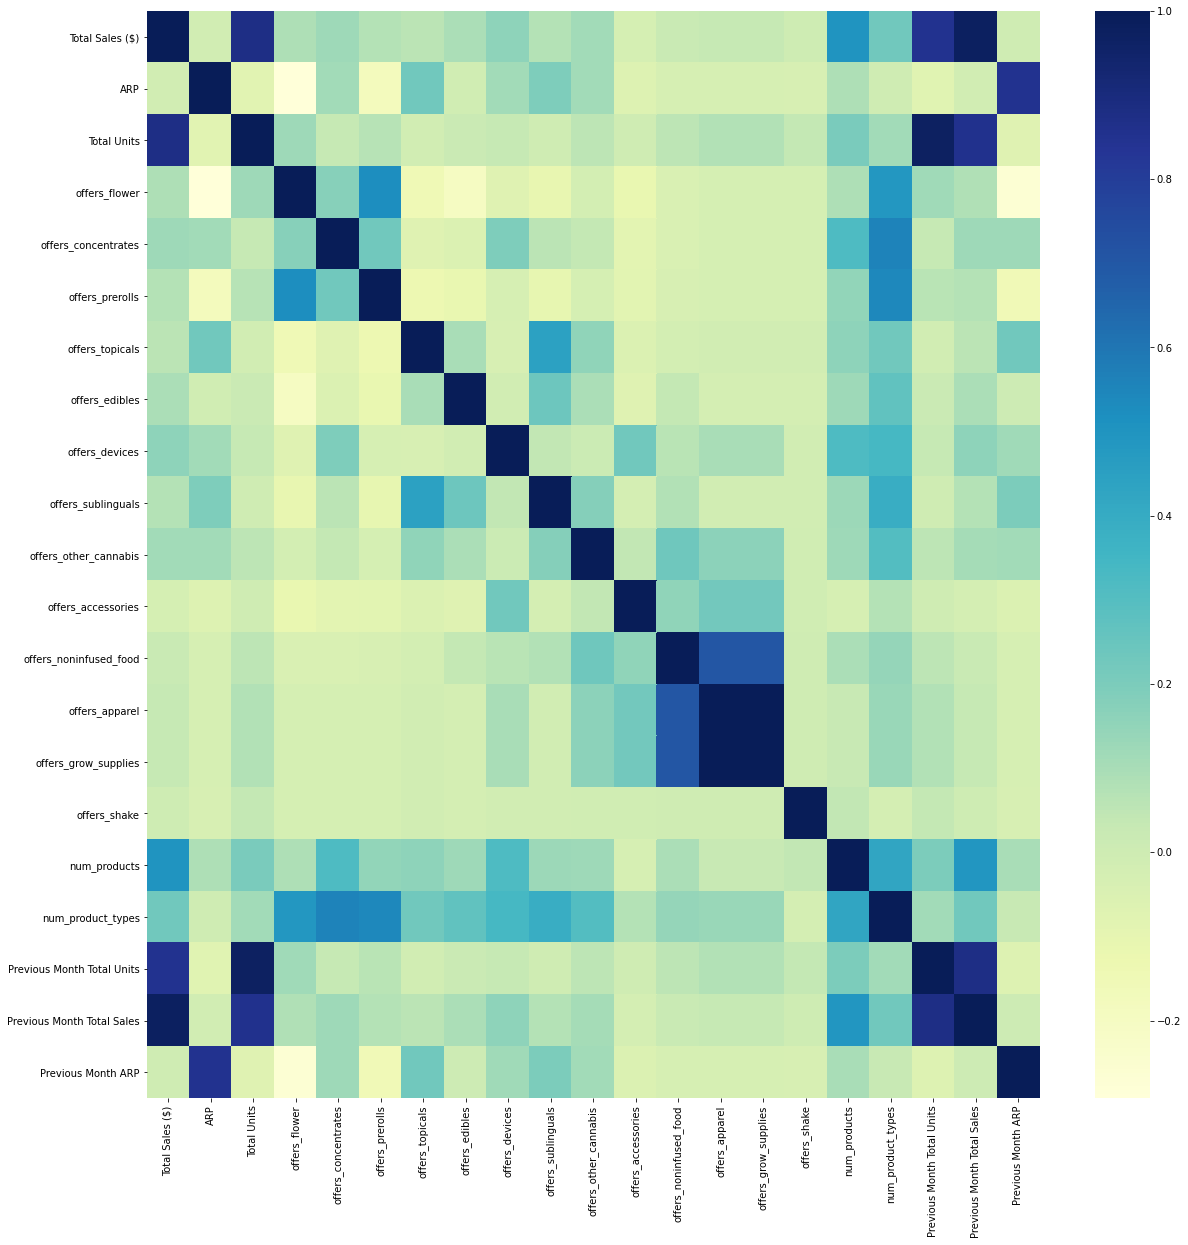

In [260]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap="YlGnBu")
df.corr()

In [ ]:
#initial thoughts on correlation matrix
#lots of things are obviously correlated (total sales / total units)
#more interesting ones:
#num_products / total sales
#num_product_types / offers_concentrates - companies that offer concentrates will have more types of products
# uh oh, not too much else, should we think about adding more features?

#feature cross 
#in terms of pipelining -
# we just need to scale
# because we already imputed all missing values (removed them)
# manually 1 hot encoded the categories (L1...L3)

